In [1]:
# Parameters
classes = 4
lossfn = "relu"
BATCH = True
EPOCHS = 450
DROPRATE = 0.2
optim = "adam"


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path as osp
from datetime import datetime

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import keras.backend as K
import keras as keras
from keras.models import Sequential,Model
from keras.metrics import mae, categorical_accuracy

from keras.layers import MaxPooling1D, Dense, Dropout, Flatten, Input, Conv1D, LeakyReLU, BatchNormalization, Softmax


Using TensorFlow backend.


In [4]:
# # curr_path = os.getcwd()
# # curr_path
# # lossfn = LeakyReLU(alpha=0.02)
# optim = 'adam'
# lossfn = 'relu'
# BATCH = False
# EPOCHS = 500
# DROPRATE = 0.4
# classes = 4

In [5]:
fold_dict = {}
if classes == 4:
    fold_dict = {"O":[0, 0,0,1],"F":[0, 0,1,0], 'S':[0, 1,0,0], "N":[1, 0,0,0]}
elif classes == 3:
    fold_dict = {"O":[0,0,1],"F":[0,1,0], 'S':[1,0,0]}
# out_len = len(fold_dict.keys())

In [6]:
TEST_ID = "cls:{}_loss:{}_bnm:{}_drop:{}_epo:{}_opt:{}".format(classes, lossfn, BATCH, DROPRATE, EPOCHS, optim)
TEST_ID

'cls:4_loss:relu_bnm:True_drop:0.2_epo:450_opt:adam'

In [7]:
data_dir = 'data'
chk_dir = 'checkpoints'
plot_dir = 'plots'
logdir = "logs/scalars/" + TEST_ID
logdir = osp.join(logdir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [8]:
def extract(fold,label):
    fold_arr = []
    labels_arr = []
    files = []
    for f in os.listdir(fold):
        files.append(osp.join(fold, f))


    for f in files:

        lines = []
        with open(f, 'r') as fw:
            for i, line in enumerate(fw):
                lines.append(int(line.split()[0]))
        lines_arr = np.array(lines)
        lines_arr=(lines_arr-np.mean(lines_arr))/np.var(lines_arr)
        fold_arr.append(lines_arr)
        labels_arr.append(label)
    return fold_arr,labels_arr

In [9]:
fin_list = []
train_X = []
train_Y = []
for key,val in fold_dict.items():
    x,y = extract(osp.join(data_dir,key),val)
    train_X.extend(x)
    train_Y.extend(y)

In [10]:
len(train_X),len(train_Y)

(400, 400)

In [11]:
in_lay = Input((4097,1))


l1 = Conv1D(4, kernel_size = 6, strides=1, padding = 'same',activation = lossfn)(in_lay)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(4, kernel_size = 5, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(10, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(10, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(15, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(15, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)
    
l1 = Conv1D(20, kernel_size = 3, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

flat = Flatten()(ml1)
flat = Dropout(DROPRATE)(flat)

flat = Dense(50)(flat)
flat = Dropout(DROPRATE)(flat)

flat = Dense(20)(flat)
flat = Dropout(DROPRATE)(flat)

flat = Dense(classes)(flat)

flat = Softmax()(flat)

model=Model(inputs = [in_lay], outputs = [flat])
model.compile(optimizer = optim, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])
#                                                                              , mae, categorical_accuracy])
# model.summary()

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = osp.join(chk_dir, 
                       "{}_{}_weights.best.hdf5".format('epilepsy', 
                                                        TEST_ID))

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.998, 
                                   patience=10, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001, 
                                   cooldown=5, 
                                   min_lr=0.0000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=150)
callbacks_list = [checkpoint, early, reduceLROnPlat, tb_callback]

In [13]:
DATA = np.array(train_X)
LABEL = np.array(train_Y)

DATA = DATA.reshape((DATA.shape[0], DATA.shape[1], 1))
# LABEL = LABEL.reshape((LABEL.shape[0], LABEL.shape[1], 1))

# DATA.shape, LABEL.shape

In [14]:
hist=model.fit(DATA,LABEL, 
               batch_size=900,
               validation_split=0.1,
               callbacks = callbacks_list,
               epochs=EPOCHS, 
               shuffle=True,
               verbose=0
              )


Epoch 00001: val_loss improved from inf to 1.41145, saving model to checkpoints/epilepsy_cls:4_loss:relu_bnm:True_drop:0.2_epo:450_opt:adam_weights.best.hdf5

Epoch 00002: val_loss did not improve from 1.41145



Epoch 00003: val_loss did not improve from 1.41145

Epoch 00004: val_loss did not improve from 1.41145

Epoch 00005: val_loss did not improve from 1.41145



Epoch 00006: val_loss did not improve from 1.41145

Epoch 00007: val_loss did not improve from 1.41145

Epoch 00008: val_loss did not improve from 1.41145



Epoch 00009: val_loss did not improve from 1.41145

Epoch 00010: val_loss did not improve from 1.41145

Epoch 00011: val_loss did not improve from 1.41145

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009980000474024565.



Epoch 00012: val_loss did not improve from 1.41145

Epoch 00013: val_loss did not improve from 1.41145

Epoch 00014: val_loss did not improve from 1.41145



Epoch 00015: val_loss did not improve from 1.41145

Epoch 00016: val_loss did not improve from 1.41145

Epoch 00017: val_loss did not improve from 1.41145



Epoch 00018: val_loss did not improve from 1.41145

Epoch 00019: val_loss did not improve from 1.41145

Epoch 00020: val_loss did not improve from 1.41145



Epoch 00021: val_loss did not improve from 1.41145

Epoch 00022: val_loss did not improve from 1.41145

Epoch 00023: val_loss did not improve from 1.41145



Epoch 00024: val_loss did not improve from 1.41145

Epoch 00025: val_loss did not improve from 1.41145

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009960040322039277.

Epoch 00026: val_loss did not improve from 1.41145



Epoch 00027: val_loss did not improve from 1.41145

Epoch 00028: val_loss did not improve from 1.41145

Epoch 00029: val_loss did not improve from 1.41145



Epoch 00030: val_loss did not improve from 1.41145

Epoch 00031: val_loss did not improve from 1.41145

Epoch 00032: val_loss did not improve from 1.41145



Epoch 00033: val_loss did not improve from 1.41145

Epoch 00034: val_loss did not improve from 1.41145

Epoch 00035: val_loss did not improve from 1.41145



Epoch 00036: val_loss did not improve from 1.41145

Epoch 00037: val_loss did not improve from 1.41145

Epoch 00038: val_loss did not improve from 1.41145



Epoch 00039: val_loss did not improve from 1.41145

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.000994011967210099.

Epoch 00040: val_loss did not improve from 1.41145

Epoch 00041: val_loss did not improve from 1.41145



Epoch 00042: val_loss did not improve from 1.41145

Epoch 00043: val_loss did not improve from 1.41145

Epoch 00044: val_loss did not improve from 1.41145



Epoch 00045: val_loss did not improve from 1.41145

Epoch 00046: val_loss did not improve from 1.41145

Epoch 00047: val_loss did not improve from 1.41145



Epoch 00048: val_loss did not improve from 1.41145

Epoch 00049: val_loss did not improve from 1.41145

Epoch 00050: val_loss did not improve from 1.41145



Epoch 00051: val_loss did not improve from 1.41145

Epoch 00052: val_loss did not improve from 1.41145

Epoch 00053: val_loss did not improve from 1.41145

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.000992023968603462.



Epoch 00054: val_loss did not improve from 1.41145

Epoch 00055: val_loss did not improve from 1.41145

Epoch 00056: val_loss did not improve from 1.41145



Epoch 00057: val_loss did not improve from 1.41145

Epoch 00058: val_loss did not improve from 1.41145

Epoch 00059: val_loss did not improve from 1.41145



Epoch 00060: val_loss did not improve from 1.41145

Epoch 00061: val_loss did not improve from 1.41145

Epoch 00062: val_loss did not improve from 1.41145



Epoch 00063: val_loss did not improve from 1.41145

Epoch 00064: val_loss did not improve from 1.41145

Epoch 00065: val_loss did not improve from 1.41145



Epoch 00066: val_loss did not improve from 1.41145

Epoch 00067: val_loss did not improve from 1.41145

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.000990039920201525.

Epoch 00068: val_loss did not improve from 1.41145



Epoch 00069: val_loss did not improve from 1.41145

Epoch 00070: val_loss did not improve from 1.41145

Epoch 00071: val_loss did not improve from 1.41145



Epoch 00072: val_loss did not improve from 1.41145

Epoch 00073: val_loss did not improve from 1.41145

Epoch 00074: val_loss did not improve from 1.41145



Epoch 00075: val_loss did not improve from 1.41145

Epoch 00076: val_loss did not improve from 1.41145

Epoch 00077: val_loss did not improve from 1.41145



Epoch 00078: val_loss did not improve from 1.41145

Epoch 00079: val_loss did not improve from 1.41145

Epoch 00080: val_loss did not improve from 1.41145



Epoch 00081: val_loss did not improve from 1.41145

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0009880598220042885.

Epoch 00082: val_loss did not improve from 1.41145

Epoch 00083: val_loss did not improve from 1.41145



Epoch 00084: val_loss did not improve from 1.41145

Epoch 00085: val_loss did not improve from 1.41145

Epoch 00086: val_loss did not improve from 1.41145



Epoch 00087: val_loss did not improve from 1.41145

Epoch 00088: val_loss did not improve from 1.41145

Epoch 00089: val_loss did not improve from 1.41145



Epoch 00090: val_loss did not improve from 1.41145

Epoch 00091: val_loss did not improve from 1.41145

Epoch 00092: val_loss did not improve from 1.41145



Epoch 00093: val_loss did not improve from 1.41145

Epoch 00094: val_loss did not improve from 1.41145

Epoch 00095: val_loss did not improve from 1.41145

Epoch 00095: ReduceLROnPlateau reducing learning rate to 0.000986083674011752.



Epoch 00096: val_loss did not improve from 1.41145

Epoch 00097: val_loss did not improve from 1.41145

Epoch 00098: val_loss did not improve from 1.41145



Epoch 00099: val_loss did not improve from 1.41145

Epoch 00100: val_loss did not improve from 1.41145

Epoch 00101: val_loss did not improve from 1.41145



Epoch 00102: val_loss did not improve from 1.41145

Epoch 00103: val_loss did not improve from 1.41145

Epoch 00104: val_loss did not improve from 1.41145



Epoch 00105: val_loss did not improve from 1.41145

Epoch 00106: val_loss did not improve from 1.41145

Epoch 00107: val_loss did not improve from 1.41145



Epoch 00108: val_loss did not improve from 1.41145

Epoch 00109: val_loss did not improve from 1.41145

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0009841114762239157.

Epoch 00110: val_loss did not improve from 1.41145



Epoch 00111: val_loss did not improve from 1.41145

Epoch 00112: val_loss did not improve from 1.41145

Epoch 00113: val_loss did not improve from 1.41145



Epoch 00114: val_loss did not improve from 1.41145

Epoch 00115: val_loss did not improve from 1.41145

Epoch 00116: val_loss did not improve from 1.41145



Epoch 00117: val_loss did not improve from 1.41145

Epoch 00118: val_loss did not improve from 1.41145

Epoch 00119: val_loss did not improve from 1.41145



Epoch 00120: val_loss did not improve from 1.41145

Epoch 00121: val_loss did not improve from 1.41145

Epoch 00122: val_loss did not improve from 1.41145



Epoch 00123: val_loss did not improve from 1.41145

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.00098214322864078.

Epoch 00124: val_loss did not improve from 1.41145

Epoch 00125: val_loss did not improve from 1.41145



Epoch 00126: val_loss did not improve from 1.41145

Epoch 00127: val_loss did not improve from 1.41145

Epoch 00128: val_loss did not improve from 1.41145



Epoch 00129: val_loss did not improve from 1.41145

Epoch 00130: val_loss did not improve from 1.41145

Epoch 00131: val_loss did not improve from 1.41145



Epoch 00132: val_loss did not improve from 1.41145

Epoch 00133: val_loss did not improve from 1.41145

Epoch 00134: val_loss did not improve from 1.41145



Epoch 00135: val_loss did not improve from 1.41145

Epoch 00136: val_loss did not improve from 1.41145

Epoch 00137: val_loss did not improve from 1.41145

Epoch 00137: ReduceLROnPlateau reducing learning rate to 0.000980178931262344.



Epoch 00138: val_loss did not improve from 1.41145

Epoch 00139: val_loss did not improve from 1.41145

Epoch 00140: val_loss did not improve from 1.41145



Epoch 00141: val_loss did not improve from 1.41145

Epoch 00142: val_loss did not improve from 1.41145

Epoch 00143: val_loss did not improve from 1.41145



Epoch 00144: val_loss did not improve from 1.41145

Epoch 00145: val_loss did not improve from 1.41145

Epoch 00146: val_loss did not improve from 1.41145



Epoch 00147: val_loss did not improve from 1.41145

Epoch 00148: val_loss did not improve from 1.41145

Epoch 00149: val_loss did not improve from 1.41145



Epoch 00150: val_loss did not improve from 1.41145

Epoch 00151: val_loss did not improve from 1.41145

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.0009782185840886085.


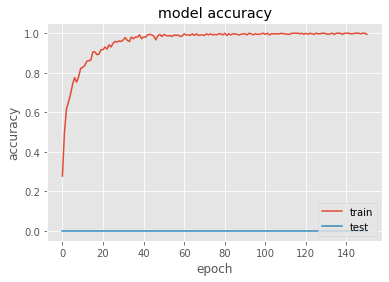

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('{}/acc_{}.png'.format(plot_dir, TEST_ID))
plt.show()

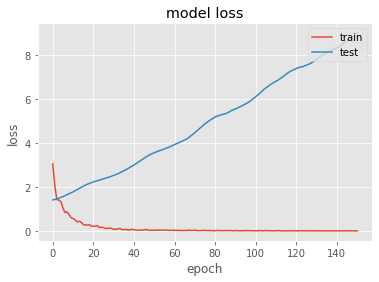

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('{}/loss_{}.png'.format(plot_dir, TEST_ID))
plt.show()

In [17]:
max(hist.history['accuracy']), max(hist.history['val_accuracy']) 

(1.0, 0.0)

In [18]:
min(hist.history['loss']), min(hist.history['val_loss']) 

(0.0025535619352012873, 1.4114515781402588)